In [48]:
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import re
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
import scipy.sparse as sparse
import string
import gc

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.metrics import f1_score
from sklearn import preprocessing 

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")
import numpy as np
from nltk.tokenize import TweetTokenizer


from sklearn.metrics.classification import classification_report, accuracy_score
from sklearn.cross_validation import cross_val_predict
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [2]:
df=pd.read_csv('./clean_data.csv',index_col='ID',encoding='utf-8')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85118 entries, T000452358 to T000543655
Data columns (total 9 columns):
Unnamed: 0            85118 non-null int64
tweet                 85118 non-null object
label                 85118 non-null object
CapitalWordsLength    85118 non-null int64
Tokenized             85118 non-null object
ListLength            85118 non-null int64
UncleanTweet          85118 non-null object
Positive Score        85118 non-null int64
Negative Score        85118 non-null int64
dtypes: int64(5), object(4)
memory usage: 6.5+ MB


In [4]:
df.isnull().sum()

Unnamed: 0            0
tweet                 0
label                 0
CapitalWordsLength    0
Tokenized             0
ListLength            0
UncleanTweet          0
Positive Score        0
Negative Score        0
dtype: int64

# EDA Word cloud

(-0.5, 399.5, 199.5, -0.5)

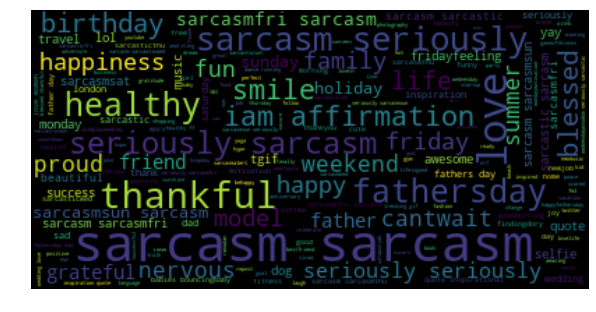

In [5]:
textsarc= " ".join(df['UncleanTweet'].apply(lambda x: " ".join(w for w in list(re.findall(r'(#[A-za-z0-9]*)', x.lower())))))
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud().generate(textsarc)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# No of Emoticons

In [ ]:
pattern=r'[\U0001f600-\U0001f650]'
df['NoE1'] = df['UncleanTweet'].apply(lambda x: len(re.findall(u'[\U0001f600-\U0001f650]', x)))

In [ ]:
del df['NoE1']

# No of punctuation

In [ ]:
df['NoP'] = df['UncleanTweet'].apply(lambda x: (x.count('!')+x.count('?')))

In [ ]:
df[df['NoP']!=0]

In [ ]:
del df['NoP']

# No. of hash

In [6]:
df['No_Hash'] = df['UncleanTweet'].apply(lambda x: (x.count('#')))

# No. of Laughter Slang

In [7]:
df['No_LSlang'] = df['UncleanTweet'].apply(lambda x: len(re.findall(r'(butlol?z|rofl|lmao|lol?z|haha|[$$]sar[$$])', x.lower())))

In [9]:
df[df['No_LSlang']!=0].head()

,Unnamed: 0,tweet,label,CapitalWordsLength,Tokenized,ListLength,UncleanTweet,Positive Score,Negative Score,No_Hash,No_LSlang
ID,,,,,,,,,,,
T000452367,9,Love having no voice,sarcastic,1,"['Love', 'voice']",2,b'Love having no voice $$SAR$$',1,0,0,1
T000452377,19,Dudes bio literally just said My name is Ba...,sarcastic,5,"['Dudes', 'bio', 'literally', 'said', 'My', 'n...",14,"b'Dudes bio literally just said "" My name is B...",2,0,0,1
T000452386,28,happy Birthday but i ate it alllol realhahaha...,sarcastic,1,"['happy', 'Birthday', 'ate', 'alllol', 'realha...",5,"b""happy Birthday but i ate it alllol realhahah...",1,0,0,1
T000452418,60,Nothing like making some great decision on sp...,sarcastic,1,"['Nothing', 'like', 'making', 'great', 'decisi...",7,b'Nothing like making some great decision on s...,1,0,0,1
T000452420,62,You think your so slick hahah,sarcastic,1,"['You', 'think', 'slick', 'hahah']",4,b'You think your so slick hahah $$SAR$$',1,0,0,2


# Popularity of #words

In [8]:
df['LexicalPopularity'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [9]:
df['HW'] = df['UncleanTweet'].apply(lambda x: " ".join((((w.replace('#sarcasm','')).replace('#sarcastic','')).replace('#notsarcasm','')).replace('#','') for w in list(re.findall(r'(#[A-za-z0-9]*)', x.lower()))))
df['HW1'] = df['UncleanTweet'].apply(lambda x: [(((w.replace('#sarcasm','')).replace('#sarcastic','')).replace('#notsarcasm','')).replace('#','') for w in list(re.findall(r'(#[A-za-z0-9]*)', x.lower()))])

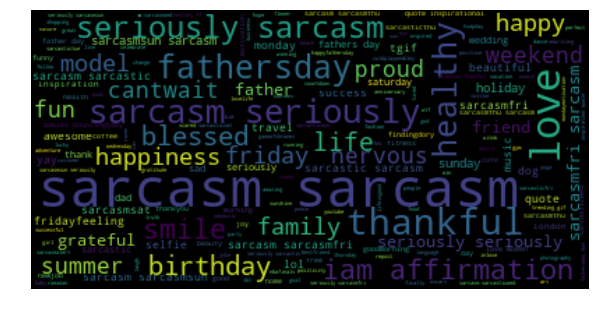

In [10]:
textSarc = " ".join(df[df['label']=='sarcastic']['HW'])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wordcloudSar = WordCloud().generate(textsarc)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloudSar, interpolation='bilinear')
plt.axis("off")
import operator
sorted_x = sorted(wordcloudSar.words_.items(), key=operator.itemgetter(1),reverse=True)
sorted_x
Top_sarcasticwords=['sarcastic','Oscars','language','wtf','lol','fml','awesome','ugh','annoyed','sorrynotsorry','yay','funny','thanks','fail','pissed','sorry','RAW','idiot','sad','bitch','TheWalkingDead']

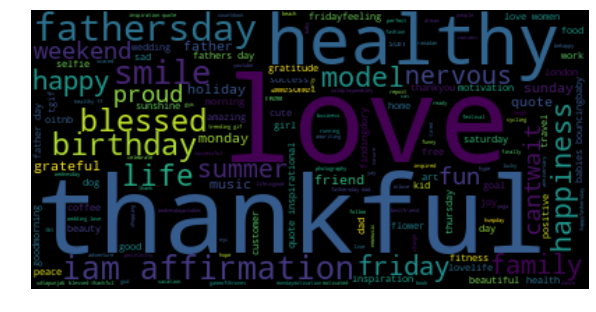

In [11]:
textNSarc = " ".join(df[df['label']=='non-sarcastic']['HW'])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wordcloudNSar = WordCloud().generate(textNSarc)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloudNSar, interpolation='bilinear')
plt.axis("off")
import operator
sorted_x = sorted(wordcloudNSar.words_.items(), key=operator.itemgetter(1),reverse=True)

Top_Nsarcasticwords=['thankful','love','healthy','affirmation','fathersday','model','blessed','smile','life','happy','birthday','happiness','cantwait','weekend','family','proud','grateful']

# Number of Top Hash Tag in Sarcastic/Non-sarcastic Word clouds

In [12]:
df['No_NSarCloud']=df['HW1'].apply(lambda x: len(list(filter(lambda k: True if k in Top_Nsarcasticwords else False,x))))
df['No_SarCloud']=df['HW1'].apply(lambda x: len(list(filter(lambda k: True if k in Top_sarcasticwords else False,x))))

'''LexPopP = lambda x: True if TextBlob(x).sentiment.polarity>0 else False
df['NoPW'] = df['Tokenized'].apply(lambda x: len(list(filter(LexPopP,x))))'''
'''LexPopN = lambda x: True if TextBlob(x).sentiment.polarity<0 else False
df['NoNW'] = df['Tokenized'].apply(lambda x: len(list(filter(LexPopN,x))))'''

In [13]:
del df['Unnamed: 0']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85118 entries, T000452358 to T000543655
Data columns (total 15 columns):
tweet                 85118 non-null object
label                 85118 non-null object
CapitalWordsLength    85118 non-null int64
Tokenized             85118 non-null object
ListLength            85118 non-null int64
UncleanTweet          85118 non-null object
Positive Score        85118 non-null int64
Negative Score        85118 non-null int64
No_Hash               85118 non-null int64
No_LSlang             85118 non-null int64
LexicalPopularity     85118 non-null float64
HW                    85118 non-null object
HW1                   85118 non-null object
No_NSarCloud          85118 non-null int64
No_SarCloud           85118 non-null int64
dtypes: float64(1), int64(8), object(6)
memory usage: 10.4+ MB


In [15]:
df.isnull().sum()

tweet                 0
label                 0
CapitalWordsLength    0
Tokenized             0
ListLength            0
UncleanTweet          0
Positive Score        0
Negative Score        0
No_Hash               0
No_LSlang             0
LexicalPopularity     0
HW                    0
HW1                   0
No_NSarCloud          0
No_SarCloud           0
dtype: int64

In [16]:
del df['HW']
del df['HW1']

# Writing Final Processed data file

In [17]:
df.to_csv('FinalModelInput.csv',encoding='utf-8')

# Preparing data for Model Execution

In [18]:
from sklearn.utils import shuffle
df = shuffle(df)

In [19]:
X=df.copy().drop(columns=['label'])
y=df['label']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

C:\Users\Hardika\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# TF-IDFVectonizer

In [21]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

In [22]:
vect_word = TfidfVectorizer(tokenizer=tokenize,max_features=1000, analyzer='word', stop_words='english', ngram_range=(1,2), dtype=np.float32) 
tr_tweetvec=vect_word.fit_transform(X_train.tweet)

In [23]:
test_tweetvec=vect_word.fit_transform(X_test.tweet)

# Horrizontal stacking

In [24]:
train = X_train[['CapitalWordsLength','ListLength','Positive Score','Negative Score','No_Hash','No_LSlang','LexicalPopularity','No_NSarCloud','No_SarCloud']]

In [25]:
test = X_test[['CapitalWordsLength','ListLength','Positive Score','Negative Score','No_Hash','No_LSlang','LexicalPopularity','No_NSarCloud','No_SarCloud']]

In [26]:
train_features = hstack([tr_tweetvec, csr_matrix(train.loc[train.index,])], 'csr')

In [27]:
test_features = hstack([test_tweetvec, csr_matrix(test.loc[test.index,])], 'csr')

# XGBoost

In [43]:
model1 = XGBClassifier()
model1.fit(train_features,y_train)
y_pred_train_xgb = model1.predict(train_features)
accuracy = accuracy_score(y_train, y_pred_train_xgb)
print(classification_report(y_train, y_pred_train_xgb))
print("Accuracy Train: %.2f%%" % (accuracy * 100.0))
f1_score(y_train, y_pred_train_xgb, average='weighted') 
y_pred_test_xgb = model1.predict(test_features)
accuracy = accuracy_score(y_test, y_pred_test_xgb)
print(classification_report(y_test, y_pred_test_xgb))
print("Accuracy Test: %.2f%%" % (accuracy * 100.0))

               precision    recall  f1-score   support

non-sarcastic       0.86      1.00      0.92     30005
    sarcastic       1.00      0.87      0.93     38089

  avg / total       0.94      0.93      0.93     68094

Accuracy Train: 92.85%
               precision    recall  f1-score   support

non-sarcastic       0.81      0.99      0.89      7402
    sarcastic       0.99      0.83      0.90      9622

  avg / total       0.91      0.90      0.90     17024

Accuracy Test: 89.71%


In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:

np.random.seed(1)

pipeline_svm = make_pipeline(vect_word, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(train_features,y_train)
grid_svm.score(test_features, y_test)

In [ ]:
grid_svm.best_params_
grid_svm.best_score_

In [35]:
svmc = SVC(kernel="linear")
svmc.fit(train_features,y_train)
preds = cross_val_predict(svmc,train_features,y_train,cv=5)
print(classification_report(y_train, preds))
print("ACCURACY Train::", accuracy_score(preds, y_train))
y_pred_test_SVC = svmc.predict(test_features)
accuracy = accuracy_score(y_test, y_pred_test_SVC)
print(classification_report(y_test, y_pred_test_SVC))
print("Accuracy Test: %.2f%%" % (accuracy * 100.0))

               precision    recall  f1-score   support

non-sarcastic       0.89      0.98      0.93     30005
    sarcastic       0.98      0.91      0.94     38089

  avg / total       0.94      0.94      0.94     68094

ACCURACY Train:: 0.9389373513084853
Accuracy Test: 87.44%


# SVM with rbf kernel

In [44]:
svmc = SVC(kernel="rbf")
svmc.fit(train_features,y_train)
preds = cross_val_predict(svmc,train_features,y_train,cv=5)
print(classification_report(y_train, preds)) 
print("ACCURACY Train::", accuracy_score(preds, y_train))
y_pred_test_SVC = svmc.predict(test_features)
print(classification_report(y_test, y_pred_test_SVC))
accuracy = accuracy_score(y_test, y_pred_test_SVC)
print("Accuracy Test: %.2f%%" % (accuracy * 100.0))

               precision    recall  f1-score   support

non-sarcastic       0.81      1.00      0.89     30005
    sarcastic       1.00      0.81      0.90     38089

  avg / total       0.91      0.89      0.89     68094

ACCURACY Train:: 0.893867301083796
               precision    recall  f1-score   support

non-sarcastic       0.80      1.00      0.89      7402
    sarcastic       1.00      0.81      0.90      9622

  avg / total       0.91      0.89      0.89     17024

Accuracy Test: 89.41%


In [37]:
svmc = SVC(kernel="poly")
svmc.fit(train_features,y_train)
preds = cross_val_predict(svmc,train_features,y_train,cv=5)
print(classification_report(y_train, preds))
print("ACCURACY Train::", accuracy_score(preds, y_train))
y_pred_test_SVC = svmc.predict(test_features)
accuracy = accuracy_score(y_test, y_pred_test_SVC)
print("Accuracy Test: %.2f%%" % (accuracy * 100.0))

               precision    recall  f1-score   support

non-sarcastic       0.79      0.95      0.86     30005
    sarcastic       0.95      0.80      0.87     38089

  avg / total       0.88      0.86      0.87     68094

ACCURACY Train:: 0.8647898493259318
Accuracy Test: 72.96%


# Random Forest

In [41]:
rf = RandomForestClassifier(random_state=9)
rf.fit(train_features,y_train)
preds = cross_val_predict(rf,train_features,y_train,cv=5)
print(classification_report(y_train, preds))
print("ACCURACY Train::", accuracy_score(preds, y_train))
y_pred_test_RF = rf.predict(test_features)
accuracy = accuracy_score(y_test, y_pred_test_RF)
print(classification_report(y_test, y_pred_test_RF))
print("Accuracy Test: %.2f%%" % (accuracy * 100.0))

               precision    recall  f1-score   support

non-sarcastic       0.90      0.97      0.93     30005
    sarcastic       0.97      0.92      0.94     38089

  avg / total       0.94      0.94      0.94     68094

ACCURACY Train:: 0.9373513084853291
               precision    recall  f1-score   support

non-sarcastic       0.83      0.93      0.88      7402
    sarcastic       0.94      0.85      0.89      9622

  avg / total       0.89      0.89      0.89     17024

Accuracy Test: 88.58%


# XGBoost with parameter tuning

In [53]:
param_grid1 = {"max_depth": [2, 3, 4],
               "min_child_weight": [4, 6, 7, 8,12],
               }
xgb = XGBClassifier(seed=9)

def myXGBoost(X_train, X_test, y_train, y_test, model, param_grid, KFold=3):
     
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = RandomizedSearchCV(model, param_grid, scoring=acc_scorer,cv=KFold)
    grid_obj = grid_obj.fit(X_train, y_train)
    y_pred=grid_obj.predict(X_test)
    accuracy=accuracy_score(y_test,y_pred)
    best_params=grid_obj.best_params_
    #auc_roc1 = roc_auc_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    return grid_obj,accuracy, best_params
xgbobj1,as1,bestparam1_=myXGBoost(train_features, test_features, y_train, y_test, xgb, param_grid1, KFold=3)
print(as1)
print(bestparam1_)
print(xgbobj1)


               precision    recall  f1-score   support

non-sarcastic       0.82      0.99      0.89      7402
    sarcastic       0.99      0.83      0.90      9622

  avg / total       0.91      0.90      0.90     17024

0.8977326127819549
{'min_child_weight': 4, 'max_depth': 4}
RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=9, silent=True,
       subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [2, 3, 4], 'min_child_weight': [4, 6, 7, 8, 12]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=mak